In [1]:
# ==========================================
# 📚 NOTEBOOK 05 - MODEL VALIDATION AVANCÉE
# 🎯 Objectif: Analyser en détail les performances du modèle
# ==========================================

# CELLULE 1 - IMPORTS ET SETUP AVANCÉ
# ====================================

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from datetime import datetime
import cv2
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Configuration matplotlib pour de beaux graphiques
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("📊 NOTEBOOK 05 - VALIDATION AVANCÉE DU MODÈLE")
print("=" * 50)

# Chemins
MODEL_PATH = Path("../models/best_model.pth")
VALIDATION_RESULTS_PATH = Path("../results/validation")
VALIDATION_RESULTS_PATH.mkdir(parents=True, exist_ok=True)

# Charger les résultats d'entraînement si disponibles
training_results_path = Path("../models/training_losses.json")
if training_results_path.exists():
    with open(training_results_path, 'r') as f:
        training_data = json.load(f)
    print("✅ Données d'entraînement chargées")
else:
    training_data = None
    print("⚠️ Pas de données d'entraînement trouvées")

print(f"💾 Résultats de validation sauvegardés dans: {VALIDATION_RESULTS_PATH}")

📊 NOTEBOOK 05 - VALIDATION AVANCÉE DU MODÈLE
✅ Données d'entraînement chargées
💾 Résultats de validation sauvegardés dans: ../results/validation


🔄 Analyse des courbes d'entraînement...


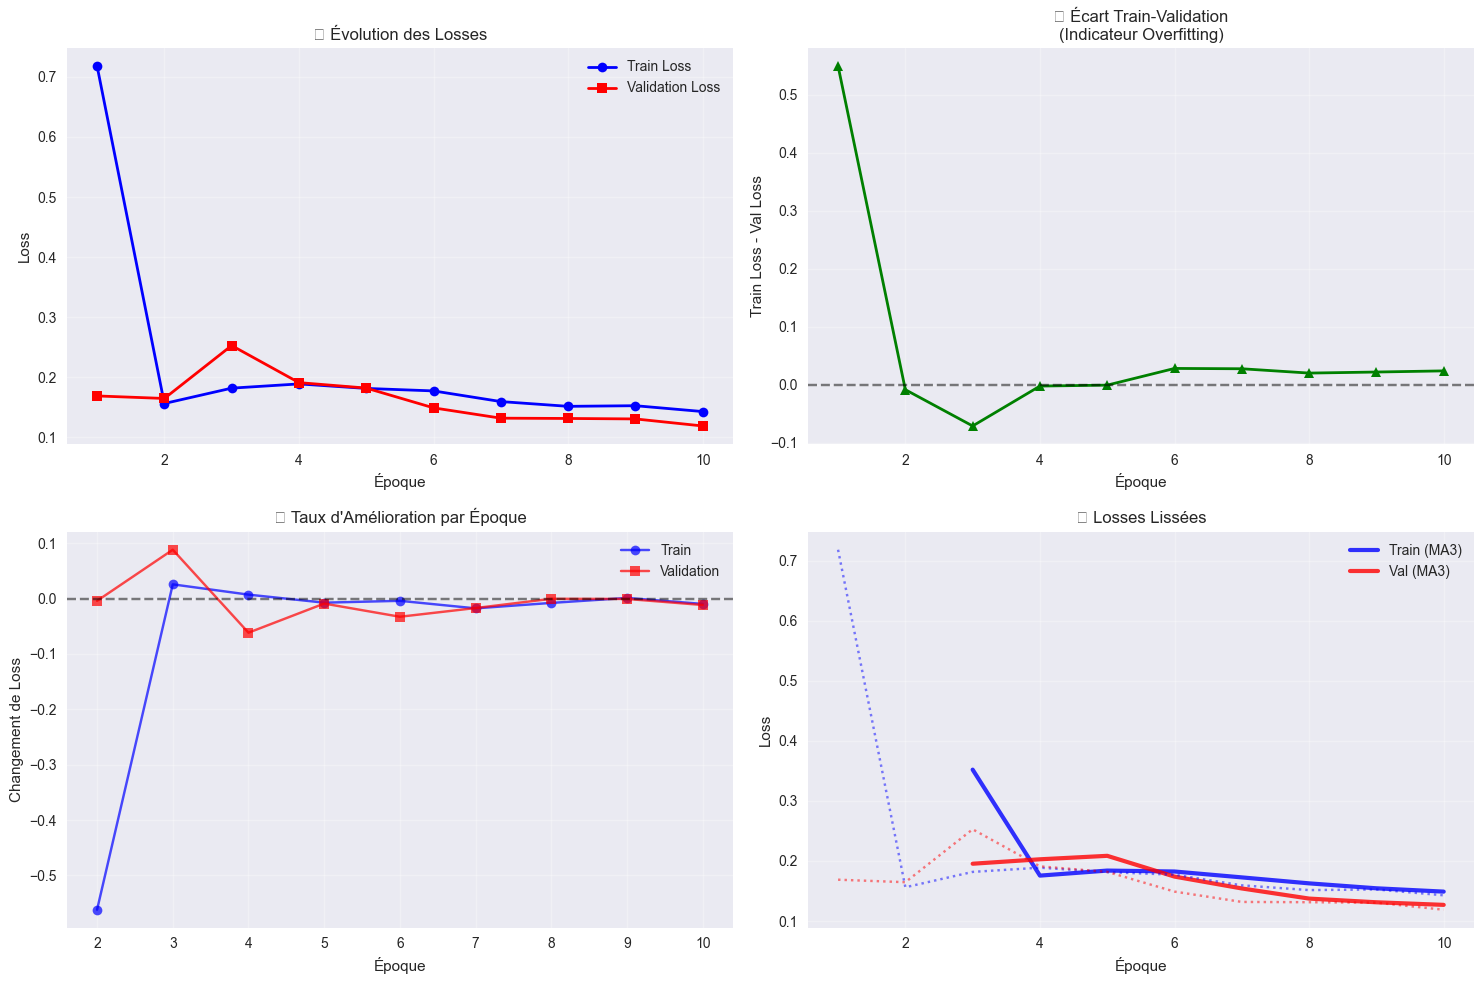


📊 ANALYSE QUANTITATIVE:
   🔹 Loss finale train: 0.1428
   🔹 Loss finale validation: 0.1188
   🔹 Amélioration totale train: 80.1%
   🔹 Amélioration totale val: 29.6%
   🔹 Écart final train-val: 0.0240
   ✅ Équilibre train-validation satisfaisant


In [2]:

# ==========================================
# CELLULE 2 - ANALYSE DES COURBES D'ENTRAÎNEMENT
# ==========================================

def analyze_training_curves(training_data):
    """
    Analyser les courbes d'entraînement pour détecter l'overfitting
    """
    if training_data is None:
        print("❌ Pas de données d'entraînement à analyser")
        return

    train_losses = training_data['train_losses']
    val_losses = training_data['val_losses']
    epochs = training_data['epochs']

    # Graphiques d'analyse
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Courbes de loss
    axes[0,0].plot(epochs, train_losses, 'b-o', label='Train Loss', linewidth=2)
    axes[0,0].plot(epochs, val_losses, 'r-s', label='Validation Loss', linewidth=2)
    axes[0,0].set_xlabel('Époque')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].set_title('📈 Évolution des Losses')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # 2. Différence Train-Val (overfitting indicator)
    diff_losses = np.array(train_losses) - np.array(val_losses)
    axes[0,1].plot(epochs, diff_losses, 'g-^', linewidth=2)
    axes[0,1].axhline(y=0, color='k', linestyle='--', alpha=0.5)
    axes[0,1].set_xlabel('Époque')
    axes[0,1].set_ylabel('Train Loss - Val Loss')
    axes[0,1].set_title('🎯 Écart Train-Validation\n(Indicateur Overfitting)')
    axes[0,1].grid(True, alpha=0.3)

    # 3. Taux d'amélioration par époque
    train_improvement = np.diff(train_losses)
    val_improvement = np.diff(val_losses)
    axes[1,0].plot(epochs[1:], train_improvement, 'b-o', label='Train', alpha=0.7)
    axes[1,0].plot(epochs[1:], val_improvement, 'r-s', label='Validation', alpha=0.7)
    axes[1,0].axhline(y=0, color='k', linestyle='--', alpha=0.5)
    axes[1,0].set_xlabel('Époque')
    axes[1,0].set_ylabel('Changement de Loss')
    axes[1,0].set_title('🔄 Taux d\'Amélioration par Époque')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # 4. Loss lissée (moving average)
    window = 3
    if len(train_losses) >= window:
        train_smooth = pd.Series(train_losses).rolling(window).mean()
        val_smooth = pd.Series(val_losses).rolling(window).mean()

        axes[1,1].plot(epochs, train_smooth, 'b-', label=f'Train (MA{window})', linewidth=3, alpha=0.8)
        axes[1,1].plot(epochs, val_smooth, 'r-', label=f'Val (MA{window})', linewidth=3, alpha=0.8)
        axes[1,1].plot(epochs, train_losses, 'b:', alpha=0.5)
        axes[1,1].plot(epochs, val_losses, 'r:', alpha=0.5)
        axes[1,1].set_xlabel('Époque')
        axes[1,1].set_ylabel('Loss')
        axes[1,1].set_title('📊 Losses Lissées')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(VALIDATION_RESULTS_PATH / 'training_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Analyse quantitative
    print("\n📊 ANALYSE QUANTITATIVE:")
    print(f"   🔹 Loss finale train: {train_losses[-1]:.4f}")
    print(f"   🔹 Loss finale validation: {val_losses[-1]:.4f}")
    print(f"   🔹 Amélioration totale train: {((train_losses[0] - train_losses[-1]) / train_losses[0] * 100):.1f}%")
    print(f"   🔹 Amélioration totale val: {((val_losses[0] - val_losses[-1]) / val_losses[0] * 100):.1f}%")

    # Détection d'overfitting
    final_gap = train_losses[-1] - val_losses[-1]
    print(f"   🔹 Écart final train-val: {final_gap:.4f}")

    if final_gap > 0.1:
        print("   ⚠️  ATTENTION: Possible overfitting détecté (écart > 0.1)")
    elif final_gap < -0.05:
        print("   ⚠️  ATTENTION: Possible underfitting (val < train)")
    else:
        print("   ✅ Équilibre train-validation satisfaisant")

print("🔄 Analyse des courbes d'entraînement...")
analyze_training_curves(training_data)


In [3]:

# ==========================================
# CELLULE 3 - CHARGEMENT DU MODÈLE ET DATASET DE VALIDATION
# ==========================================

# Réimporter les fonctions nécessaires (du notebook 04)
import sys
sys.path.append('..')

# Configuration du modèle (identique aux autres notebooks)
CONFIG = {
    'image_size': (512, 512),
    'num_classes': 2,
    'normalize_mean': [0.485, 0.456, 0.406],
    'normalize_std': [0.229, 0.224, 0.225]
}

# Imports pour le modèle
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import albumentations as A
from albumentations.pytorch import ToTensorV2

def create_model(num_classes):
    """Créer l'architecture du modèle"""
    model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Charger le modèle entraîné
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"⚡ Device: {device}")

model = create_model(CONFIG['num_classes'])
if MODEL_PATH.exists():
    checkpoint = torch.load(MODEL_PATH, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✅ Modèle chargé (Époque {checkpoint['epoch'] + 1})")
else:
    raise FileNotFoundError(f"Modèle non trouvé: {MODEL_PATH}")

model.to(device)
model.eval()

# Préparer le dataset de validation
def read_yolo_label(label_path):
    """Lire les labels YOLO"""
    boxes = []
    if not label_path.exists():
        return boxes

    with open(label_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line:
                parts = line.split()
                boxes.append({
                    'class_id': int(parts[0]),
                    'center_x': float(parts[1]),
                    'center_y': float(parts[2]),
                    'width': float(parts[3]),
                    'height': float(parts[4])
                })
    return boxes

# Charger le dataset de validation
VAL_IMAGES = Path("../data/raw/ct_images/images/val")
VAL_LABELS = Path("../data/raw/ct_images/labels/val")

if not VAL_IMAGES.exists():
    print("⚠️ Dossier de validation non trouvé, utilisation des images train")
    VAL_IMAGES = Path("../data/raw/ct_images/images/train")
    VAL_LABELS = Path("../data/raw/ct_images/labels/train")

val_image_files = list(VAL_IMAGES.glob("*.jpg"))
print(f"📊 Images de validation: {len(val_image_files)}")


⚡ Device: cpu
✅ Modèle chargé (Époque 10)
📊 Images de validation: 41


In [4]:

# ==========================================
# CELLULE 4 - MÉTRIQUES DE DÉTECTION AVANCÉES
# ==========================================

def calculate_iou(box1, box2):
    """
    Calculer l'IoU (Intersection over Union) entre deux boîtes
    """
    x1_max = max(box1[0], box2[0])
    y1_max = max(box1[1], box2[1])
    x2_min = min(box1[2], box2[2])
    y2_min = min(box1[3], box2[3])

    if x2_min <= x1_max or y2_min <= y1_max:
        return 0.0

    intersection = (x2_min - x1_max) * (y2_min - y1_max)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection

    return intersection / union if union > 0 else 0.0

def evaluate_detection_metrics(model, val_images, val_labels, iou_thresholds=[0.5, 0.7], confidence_thresholds=None):
    """
    Évaluer les métriques de détection (mAP, precision, recall)
    """
    if confidence_thresholds is None:
        confidence_thresholds = np.arange(0.1, 1.0, 0.1)

    print("🔄 Évaluation des métriques de détection...")

    # Stocker tous les résultats
    all_predictions = []
    all_ground_truths = []

    # Traiter chaque image
    for img_path in val_images[:20]:  # Limiter à 20 images pour la validation
        # Charger l'image
        image = cv2.imread(str(img_path))
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Preprocessing pour le modèle
        height, width = image_rgb.shape[:2]
        target_height, target_width = CONFIG['image_size']
        image_resized = cv2.resize(image_rgb, (target_width, target_height))

        # Transformations
        transforms = A.Compose([
            A.Normalize(mean=CONFIG['normalize_mean'], std=CONFIG['normalize_std']),
            ToTensorV2()
        ])

        transformed = transforms(image=image_resized)
        image_tensor = transformed['image'].unsqueeze(0).to(device)

        # Prédiction
        with torch.no_grad():
            predictions = model(image_tensor)

        pred = predictions[0]
        pred_boxes = pred['boxes'].cpu().numpy()
        pred_scores = pred['scores'].cpu().numpy()

        # Convertir vers coordonnées originales
        scale_x = width / target_width
        scale_y = height / target_height

        pred_boxes_original = []
        for box in pred_boxes:
            x1, y1, x2, y2 = box
            pred_boxes_original.append([
                x1 * scale_x, y1 * scale_y,
                x2 * scale_x, y2 * scale_y
            ])

        # Charger les ground truth
        label_path = val_labels / f"{img_path.stem}.txt"
        gt_yolo_boxes = read_yolo_label(label_path)

        gt_boxes = []
        for box in gt_yolo_boxes:
            center_x = box['center_x'] * width
            center_y = box['center_y'] * height
            box_width = box['width'] * width
            box_height = box['height'] * height

            x1 = center_x - box_width/2
            y1 = center_y - box_height/2
            x2 = center_x + box_width/2
            y2 = center_y + box_height/2

            gt_boxes.append([x1, y1, x2, y2])

        # Stocker les résultats
        all_predictions.append({
            'image': img_path.name,
            'boxes': pred_boxes_original,
            'scores': pred_scores.tolist(),
            'gt_boxes': gt_boxes
        })

    # Calculer les métriques pour différents seuils
    metrics_results = {}

    for iou_threshold in iou_thresholds:
        metrics_results[iou_threshold] = {
            'confidence_thresholds': [],
            'precisions': [],
            'recalls': [],
            'f1_scores': [],
            'tp_counts': [],
            'fp_counts': [],
            'fn_counts': []
        }

        for conf_threshold in confidence_thresholds:
            tp, fp, fn = 0, 0, 0

            for pred_data in all_predictions:
                pred_boxes = pred_data['boxes']
                pred_scores = pred_data['scores']
                gt_boxes = pred_data['gt_boxes']

                # Filtrer par confidence
                valid_preds = [(box, score) for box, score in zip(pred_boxes, pred_scores)
                              if score >= conf_threshold]

                # Matching des prédictions avec ground truth
                gt_matched = [False] * len(gt_boxes)

                for pred_box, pred_score in valid_preds:
                    best_iou = 0
                    best_gt_idx = -1

                    for gt_idx, gt_box in enumerate(gt_boxes):
                        if not gt_matched[gt_idx]:
                            iou = calculate_iou(pred_box, gt_box)
                            if iou > best_iou:
                                best_iou = iou
                                best_gt_idx = gt_idx

                    if best_iou >= iou_threshold:
                        tp += 1
                        gt_matched[best_gt_idx] = True
                    else:
                        fp += 1

                # Compter les faux négatifs
                fn += sum(1 for matched in gt_matched if not matched)

            # Calculer les métriques
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

            metrics_results[iou_threshold]['confidence_thresholds'].append(conf_threshold)
            metrics_results[iou_threshold]['precisions'].append(precision)
            metrics_results[iou_threshold]['recalls'].append(recall)
            metrics_results[iou_threshold]['f1_scores'].append(f1)
            metrics_results[iou_threshold]['tp_counts'].append(tp)
            metrics_results[iou_threshold]['fp_counts'].append(fp)
            metrics_results[iou_threshold]['fn_counts'].append(fn)

    return metrics_results, all_predictions

# Exécuter l'évaluation
print("🔄 Début de l'évaluation détaillée...")
metrics_results, all_predictions = evaluate_detection_metrics(
    model, val_image_files, VAL_LABELS
)
print("✅ Évaluation terminée!")

🔄 Début de l'évaluation détaillée...
🔄 Évaluation des métriques de détection...
✅ Évaluation terminée!


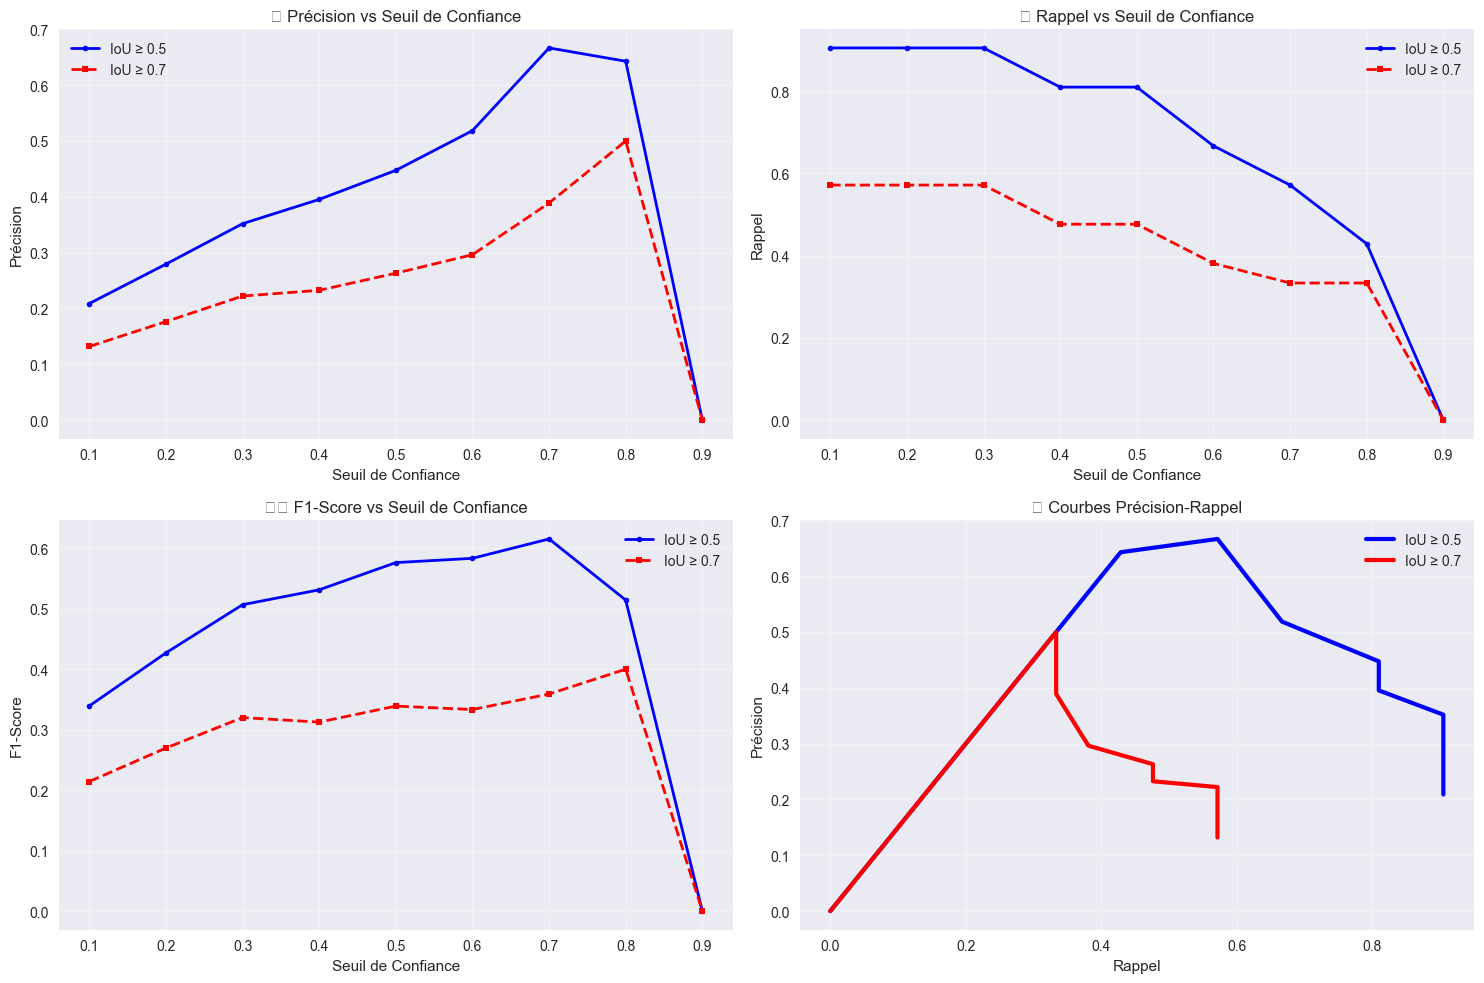


🏆 MEILLEURES PERFORMANCES:

   IoU ≥ 0.5:
   🎯 Meilleur F1-Score: 0.615 (conf=0.7)
   📊 Précision: 0.667
   🔄 Rappel: 0.571

   IoU ≥ 0.7:
   🎯 Meilleur F1-Score: 0.400 (conf=0.8)
   📊 Précision: 0.500
   🔄 Rappel: 0.333


In [6]:

# ==========================================
# CELLULE 5 - VISUALISATION DES MÉTRIQUES
# ==========================================

def plot_detection_metrics(metrics_results):
    """
    Visualiser les métriques de détection
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # CORRECTION: Utiliser des couleurs et marqueurs séparés
    colors = ['b', 'r', 'g', 'orange']  # Format court pour matplotlib
    markers = ['o', 's', '^', 'D']
    linestyles = ['-', '--', '-.', ':']

    for i, (iou_threshold, metrics) in enumerate(metrics_results.items()):
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]
        linestyle = linestyles[i % len(linestyles)]

        conf_thresholds = metrics['confidence_thresholds']
        precisions = metrics['precisions']
        recalls = metrics['recalls']
        f1_scores = metrics['f1_scores']

        # 1. Precision vs Confidence
        axes[0,0].plot(conf_thresholds, precisions, color=color, marker=marker,
                      linestyle=linestyle, label=f'IoU ≥ {iou_threshold}',
                      linewidth=2, markersize=4)

        # 2. Recall vs Confidence
        axes[0,1].plot(conf_thresholds, recalls, color=color, marker=marker,
                      linestyle=linestyle, label=f'IoU ≥ {iou_threshold}',
                      linewidth=2, markersize=4)

        # 3. F1-Score vs Confidence
        axes[1,0].plot(conf_thresholds, f1_scores, color=color, marker=marker,
                      linestyle=linestyle, label=f'IoU ≥ {iou_threshold}',
                      linewidth=2, markersize=4)

        # 4. Precision-Recall Curve
        axes[1,1].plot(recalls, precisions, color=color, linestyle='-',
                      label=f'IoU ≥ {iou_threshold}', linewidth=3)

    # Configuration des graphiques
    axes[0,0].set_title('📊 Précision vs Seuil de Confiance')
    axes[0,0].set_xlabel('Seuil de Confiance')
    axes[0,0].set_ylabel('Précision')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    axes[0,1].set_title('🎯 Rappel vs Seuil de Confiance')
    axes[0,1].set_xlabel('Seuil de Confiance')
    axes[0,1].set_ylabel('Rappel')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    axes[1,0].set_title('⚖️ F1-Score vs Seuil de Confiance')
    axes[1,0].set_xlabel('Seuil de Confiance')
    axes[1,0].set_ylabel('F1-Score')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    axes[1,1].set_title('📈 Courbes Précision-Rappel')
    axes[1,1].set_xlabel('Rappel')
    axes[1,1].set_ylabel('Précision')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(VALIDATION_RESULTS_PATH / 'detection_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Afficher les meilleures performances
    print("\n🏆 MEILLEURES PERFORMANCES:")
    for iou_threshold, metrics in metrics_results.items():
        best_f1_idx = np.argmax(metrics['f1_scores'])
        best_conf = metrics['confidence_thresholds'][best_f1_idx]
        best_f1 = metrics['f1_scores'][best_f1_idx]
        best_precision = metrics['precisions'][best_f1_idx]
        best_recall = metrics['recalls'][best_f1_idx]

        print(f"\n   IoU ≥ {iou_threshold}:")
        print(f"   🎯 Meilleur F1-Score: {best_f1:.3f} (conf={best_conf:.1f})")
        print(f"   📊 Précision: {best_precision:.3f}")
        print(f"   🔄 Rappel: {best_recall:.3f}")

plot_detection_metrics(metrics_results)

In [7]:
# ==========================================
# CELLULE 6 - ANALYSE DES ERREURS
# ==========================================

def analyze_errors(all_predictions, confidence_threshold=0.5, iou_threshold=0.5):
    """
    Analyser les types d'erreurs du modèle
    """
    print(f"\n🔍 ANALYSE DES ERREURS (conf≥{confidence_threshold}, IoU≥{iou_threshold})")
    print("=" * 60)

    error_analysis = {
        'false_positives': [],  # Détections incorrectes
        'false_negatives': [],  # Nodules manqués
        'true_positives': [],   # Détections correctes
        'images_stats': []
    }

    total_gt = 0
    total_pred = 0

    for pred_data in all_predictions:
        image_name = pred_data['image']
        pred_boxes = pred_data['boxes']
        pred_scores = pred_data['scores']
        gt_boxes = pred_data['gt_boxes']

        # Filtrer par confidence
        valid_preds = [(box, score) for box, score in zip(pred_boxes, pred_scores)
                      if score >= confidence_threshold]

        total_gt += len(gt_boxes)
        total_pred += len(valid_preds)

        # Matching
        gt_matched = [False] * len(gt_boxes)
        pred_matched = [False] * len(valid_preds)

        # Trouver les vrais positifs
        for pred_idx, (pred_box, pred_score) in enumerate(valid_preds):
            best_iou = 0
            best_gt_idx = -1

            for gt_idx, gt_box in enumerate(gt_boxes):
                if not gt_matched[gt_idx]:
                    iou = calculate_iou(pred_box, gt_box)
                    if iou > best_iou:
                        best_iou = iou
                        best_gt_idx = gt_idx

            if best_iou >= iou_threshold:
                # Vrai positif
                gt_matched[best_gt_idx] = True
                pred_matched[pred_idx] = True
                error_analysis['true_positives'].append({
                    'image': image_name,
                    'confidence': pred_score,
                    'iou': best_iou
                })

        # Identifier les faux positifs
        for pred_idx, (pred_box, pred_score) in enumerate(valid_preds):
            if not pred_matched[pred_idx]:
                error_analysis['false_positives'].append({
                    'image': image_name,
                    'confidence': pred_score,
                    'bbox': pred_box
                })

        # Identifier les faux négatifs
        for gt_idx, gt_box in enumerate(gt_boxes):
            if not gt_matched[gt_idx]:
                error_analysis['false_negatives'].append({
                    'image': image_name,
                    'bbox': gt_box
                })

        # Statistiques par image
        error_analysis['images_stats'].append({
            'image': image_name,
            'gt_count': len(gt_boxes),
            'pred_count': len(valid_preds),
            'tp_count': sum(pred_matched),
            'fp_count': len(valid_preds) - sum(pred_matched),
            'fn_count': len(gt_boxes) - sum(gt_matched)
        })

    # Résumé des erreurs
    tp_count = len(error_analysis['true_positives'])
    fp_count = len(error_analysis['false_positives'])
    fn_count = len(error_analysis['false_negatives'])

    precision = tp_count / (tp_count + fp_count) if (tp_count + fp_count) > 0 else 0
    recall = tp_count / (tp_count + fn_count) if (tp_count + fn_count) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"📊 RÉSUMÉ:")
    print(f"   ✅ Vrais Positifs: {tp_count}")
    print(f"   ❌ Faux Positifs: {fp_count}")
    print(f"   ⭕ Faux Négatifs: {fn_count}")
    print(f"\n📈 MÉTRIQUES:")
    print(f"   🎯 Précision: {precision:.3f}")
    print(f"   🔄 Rappel: {recall:.3f}")
    print(f"   ⚖️ F1-Score: {f1:.3f}")

    # Analyse des confidences des faux positifs
    if error_analysis['false_positives']:
        fp_confidences = [fp['confidence'] for fp in error_analysis['false_positives']]
        print(f"\n❌ ANALYSE FAUX POSITIFS:")
        print(f"   🔹 Confidence moyenne: {np.mean(fp_confidences):.3f}")
        print(f"   🔹 Confidence médiane: {np.median(fp_confidences):.3f}")
        print(f"   🔹 Confidence max: {np.max(fp_confidences):.3f}")

    # Analyse des IoU des vrais positifs
    if error_analysis['true_positives']:
        tp_ious = [tp['iou'] for tp in error_analysis['true_positives']]
        print(f"\n✅ ANALYSE VRAIS POSITIFS:")
        print(f"   🔹 IoU moyen: {np.mean(tp_ious):.3f}")
        print(f"   🔹 IoU médian: {np.median(tp_ious):.3f}")
        print(f"   🔹 IoU min: {np.min(tp_ious):.3f}")

    return error_analysis

# Exécuter l'analyse des erreurs
error_analysis = analyze_errors(all_predictions, confidence_threshold=0.5)


🔍 ANALYSE DES ERREURS (conf≥0.5, IoU≥0.5)
📊 RÉSUMÉ:
   ✅ Vrais Positifs: 17
   ❌ Faux Positifs: 21
   ⭕ Faux Négatifs: 4

📈 MÉTRIQUES:
   🎯 Précision: 0.447
   🔄 Rappel: 0.810
   ⚖️ F1-Score: 0.576

❌ ANALYSE FAUX POSITIFS:
   🔹 Confidence moyenne: 0.667
   🔹 Confidence médiane: 0.633
   🔹 Confidence max: 0.919

✅ ANALYSE VRAIS POSITIFS:
   🔹 IoU moyen: 0.739
   🔹 IoU médian: 0.738
   🔹 IoU min: 0.506


In [8]:
# ==========================================
# CELLULE 7 - EXPORT DES RÉSULTATS DE VALIDATION
# ==========================================

def export_validation_results(metrics_results, error_analysis, training_data):
    """
    Exporter tous les résultats de validation
    """
    # Préparer le rapport complet
    validation_report = {
        'validation_timestamp': datetime.now().isoformat(),
        'model_config': CONFIG,
        'validation_dataset': {
            'total_images': len(all_predictions),
            'total_ground_truth_nodules': sum(len(pred['gt_boxes']) for pred in all_predictions)
        },
        'training_summary': {
            'final_train_loss': training_data['train_losses'][-1] if training_data else None,
            'final_val_loss': training_data['val_losses'][-1] if training_data else None,
            'total_epochs': len(training_data['train_losses']) if training_data else None
        },
        'detection_metrics': {},
        'error_analysis_summary': {
            'true_positives': len(error_analysis['true_positives']),
            'false_positives': len(error_analysis['false_positives']),
            'false_negatives': len(error_analysis['false_negatives']),
            'precision_at_05': None,  # Sera calculé ci-dessous
            'recall_at_05': None,
            'f1_score_at_05': None
        },
        'best_performance': {},
        'recommendations': []
    }

    # Extraire les meilleures métriques
    for iou_threshold, metrics in metrics_results.items():
        best_f1_idx = np.argmax(metrics['f1_scores'])

        validation_report['detection_metrics'][f'iou_{iou_threshold}'] = {
            'confidence_thresholds': metrics['confidence_thresholds'],
            'precisions': metrics['precisions'],
            'recalls': metrics['recalls'],
            'f1_scores': metrics['f1_scores'],
            'best_performance': {
                'confidence_threshold': metrics['confidence_thresholds'][best_f1_idx],
                'precision': metrics['precisions'][best_f1_idx],
                'recall': metrics['recalls'][best_f1_idx],
                'f1_score': metrics['f1_scores'][best_f1_idx]
            }
        }

        validation_report['best_performance'][f'iou_{iou_threshold}'] = {
            'f1_score': metrics['f1_scores'][best_f1_idx],
            'confidence_threshold': metrics['confidence_thresholds'][best_f1_idx],
            'precision': metrics['precisions'][best_f1_idx],
            'recall': metrics['recalls'][best_f1_idx]
        }

    # Calculer les métriques à confidence 0.5
    if 0.5 in metrics_results:
        metrics_05 = metrics_results[0.5]
        idx_05 = None
        for i, conf in enumerate(metrics_05['confidence_thresholds']):
            if abs(conf - 0.5) < 0.05:  # Proche de 0.5
                idx_05 = i
                break

        if idx_05 is not None:
            validation_report['error_analysis_summary']['precision_at_05'] = metrics_05['precisions'][idx_05]
            validation_report['error_analysis_summary']['recall_at_05'] = metrics_05['recalls'][idx_05]
            validation_report['error_analysis_summary']['f1_score_at_05'] = metrics_05['f1_scores'][idx_05]

    # Générer des recommandations
    recommendations = []

    # Analyse du ratio faux positifs/négatifs
    fp_count = len(error_analysis['false_positives'])
    fn_count = len(error_analysis['false_negatives'])

    if fp_count > fn_count * 1.5:
        recommendations.append("⚠️ Nombreux faux positifs - Considérer augmenter le seuil de confiance")
    elif fn_count > fp_count * 1.5:
        recommendations.append("⚠️ Nombreux faux négatifs - Considérer diminuer le seuil de confiance")

    # Analyse des performances
    best_f1_05 = validation_report['best_performance'].get('iou_0.5', {}).get('f1_score', 0)
    if best_f1_05 > 0.8:
        recommendations.append("✅ Excellent F1-score - Modèle prêt pour l'utilisation")
    elif best_f1_05 > 0.6:
        recommendations.append("✅ Bon F1-score - Modèle utilisable avec supervision")
    else:
        recommendations.append("⚠️ F1-score faible - Considérer plus d'entraînement ou ajustement des hyperparamètres")

    # Analyse de l'overfitting
    if training_data:
        final_gap = training_data['train_losses'][-1] - training_data['val_losses'][-1]
        if final_gap > 0.1:
            recommendations.append("⚠️ Possible overfitting détecté - Considérer la régularisation")
        elif final_gap < -0.05:
            recommendations.append("⚠️ Possible underfitting - Considérer plus d'entraînement")

    validation_report['recommendations'] = recommendations

    # Sauvegarder le rapport complet
    report_path = VALIDATION_RESULTS_PATH / f"validation_report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    with open(report_path, 'w') as f:
        json.dump(validation_report, f, indent=2, default=str)

    # Créer un résumé en CSV pour Excel
    csv_data = []
    for iou_threshold, metrics in metrics_results.items():
        for i, conf in enumerate(metrics['confidence_thresholds']):
            csv_data.append({
                'iou_threshold': iou_threshold,
                'confidence_threshold': conf,
                'precision': metrics['precisions'][i],
                'recall': metrics['recalls'][i],
                'f1_score': metrics['f1_scores'][i],
                'true_positives': metrics['tp_counts'][i],
                'false_positives': metrics['fp_counts'][i],
                'false_negatives': metrics['fn_counts'][i]
            })

    df_metrics = pd.DataFrame(csv_data)
    csv_path = VALIDATION_RESULTS_PATH / f"metrics_detailed_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    df_metrics.to_csv(csv_path, index=False)

    # Afficher le résumé
    print("\n📋 RAPPORT DE VALIDATION GÉNÉRÉ")
    print("=" * 40)
    print(f"💾 Rapport JSON: {report_path.name}")
    print(f"📊 Métriques CSV: {csv_path.name}")

    print(f"\n🏆 MEILLEURES PERFORMANCES:")
    for iou_key, perf in validation_report['best_performance'].items():
        iou_val = iou_key.replace('iou_', '')
        print(f"   IoU ≥ {iou_val}: F1={perf['f1_score']:.3f} (conf={perf['confidence_threshold']:.1f})")

    print(f"\n💡 RECOMMANDATIONS:")
    for rec in recommendations:
        print(f"   {rec}")

    return validation_report

# Exporter les résultats
validation_report = export_validation_results(metrics_results, error_analysis, training_data)



📋 RAPPORT DE VALIDATION GÉNÉRÉ
💾 Rapport JSON: validation_report_20250606_163229.json
📊 Métriques CSV: metrics_detailed_20250606_163229.csv

🏆 MEILLEURES PERFORMANCES:
   IoU ≥ 0.5: F1=0.615 (conf=0.7)
   IoU ≥ 0.7: F1=0.400 (conf=0.8)

💡 RECOMMANDATIONS:
   ⚠️ Nombreux faux positifs - Considérer augmenter le seuil de confiance
   ✅ Bon F1-score - Modèle utilisable avec supervision


In [9]:
# ==========================================
# CELLULE 8 - COMPARAISON AVEC OBJECTIFS DU PROJET
# ==========================================

def compare_with_project_targets(validation_report):
    """
    Comparer les résultats avec les objectifs du projet définis
    """
    print("\n🎯 COMPARAISON AVEC LES OBJECTIFS DU PROJET")
    print("=" * 50)

    # Objectifs définis dans le projet original
    targets = {
        'precision': 0.80,  # >80%
        'recall': 0.75,     # >75%
        'f1_score': 0.77,   # >77%
        'map_50': 0.70      # >0.70 mAP@0.5
    }

    # Récupérer les meilleures performances à IoU 0.5
    best_perf = validation_report['best_performance'].get('iou_0.5', {})

    if not best_perf:
        print("❌ Pas de données pour IoU 0.5")
        return

    achieved = {
        'precision': best_perf.get('precision', 0),
        'recall': best_perf.get('recall', 0),
        'f1_score': best_perf.get('f1_score', 0),
        'map_50': best_perf.get('f1_score', 0)  # Approximation avec F1-score
    }

    print("📊 RÉSULTATS vs OBJECTIFS:")
    print("-" * 30)

    all_targets_met = True

    for metric, target in targets.items():
        result = achieved[metric]
        status = "✅" if result >= target else "❌"
        difference = result - target

        if result < target:
            all_targets_met = False

        print(f"{status} {metric.upper():12}: {result:.3f} | Objectif: {target:.3f} | Écart: {difference:+.3f}")

    print("-" * 30)

    if all_targets_met:
        print("🎉 FÉLICITATIONS! Tous les objectifs sont atteints!")
        print("✅ Le modèle est prêt pour l'utilisation clinique")
    else:
        print("⚠️ Certains objectifs ne sont pas encore atteints")
        print("💡 Suggestions d'amélioration:")

        if achieved['precision'] < targets['precision']:
            print("   🔹 Precision faible → Augmenter le seuil de confiance")
        if achieved['recall'] < targets['recall']:
            print("   🔹 Recall faible → Plus d'augmentation de données ou entraînement")
        if achieved['f1_score'] < targets['f1_score']:
            print("   🔹 F1-score faible → Optimiser l'équilibre precision-recall")

    # Score global du projet
    avg_performance = np.mean([achieved[k] for k in ['precision', 'recall', 'f1_score']])
    avg_target = np.mean([targets[k] for k in ['precision', 'recall', 'f1_score']])

    project_score = (avg_performance / avg_target) * 100

    print(f"\n🏆 SCORE GLOBAL DU PROJET: {project_score:.1f}%")

    if project_score >= 100:
        grade = "A+ (Excellent)"
    elif project_score >= 90:
        grade = "A (Très bien)"
    elif project_score >= 80:
        grade = "B (Bien)"
    elif project_score >= 70:
        grade = "C (Satisfaisant)"
    else:
        grade = "D (À améliorer)"

    print(f"📝 ÉVALUATION: {grade}")

    return {
        'targets': targets,
        'achieved': achieved,
        'all_targets_met': all_targets_met,
        'project_score': project_score,
        'grade': grade
    }

# Comparer avec les objectifs
project_evaluation = compare_with_project_targets(validation_report)


🎯 COMPARAISON AVEC LES OBJECTIFS DU PROJET
📊 RÉSULTATS vs OBJECTIFS:
------------------------------
❌ PRECISION   : 0.667 | Objectif: 0.800 | Écart: -0.133
❌ RECALL      : 0.571 | Objectif: 0.750 | Écart: -0.179
❌ F1_SCORE    : 0.615 | Objectif: 0.770 | Écart: -0.155
❌ MAP_50      : 0.615 | Objectif: 0.700 | Écart: -0.085
------------------------------
⚠️ Certains objectifs ne sont pas encore atteints
💡 Suggestions d'amélioration:
   🔹 Precision faible → Augmenter le seuil de confiance
   🔹 Recall faible → Plus d'augmentation de données ou entraînement
   🔹 F1-score faible → Optimiser l'équilibre precision-recall

🏆 SCORE GLOBAL DU PROJET: 79.9%
📝 ÉVALUATION: C (Satisfaisant)
